Test the model from saved params model

load the pth file from saved_model! The best record.

the A2C-Best.pth in root file will be replaced during training

In [13]:
import time
import torch
import torch.nn as nn
import gym, gym_unbalanced_disk, time
import numpy as np
import matplotlib.pyplot as plt

import os


Discretize

In [14]:
def normalize(theta):
    return (theta+np.pi)%(2*np.pi) - np.pi # map to [-pi,pi]

class Discretize(gym.Wrapper): # only discrete action
    def __init__(self,env,num_act=7):
        super(Discretize,self).__init__(env) #sets self.env , call function from father calss
        self.num_act = num_act
        self.action_space = gym.spaces.Discrete(self.num_act)
        self.alow, self.ahigh = env.action_space.low, env.action_space.high
        # action discrete list.--no need! since we map action from index like to (-3,3)
        # self.stepsize = (self.ahigh-self.alow)/self.num_act
        # self.act_values_list = np.arange(self.alow,self.ahigh,self.stepsize)
        
    def step(self,action):
        action = self.discretize_act(action)
        obs,_,done,info = self.env.step(action)
        # velocity from (-infi,infi) to (-pi,pi)
        obs[0] = normalize(obs[0])
        reward = self.reward_fc(obs,action=action)

        return np.array(obs),reward,done,info

    def discretize_act(self,action): ##!!! action input is from 0 1 2... num-1;  output is -3,...0,...3
        # stepsize = (self.ahigh-self.alow)/self.num_act
        # values_list = np.arange(self.alow,self.ahigh,stepsize)
        # out = values_list[np.abs(values_list-action).argmin()] 
        step_size = (self.ahigh-self.alow)/(self.num_act-1)
        action = action*step_size +self.alow
        return action
    
    def reward_fc(self,obs,action):
        theta = normalize(obs[0]) # already mapped so [-pi,pi]
        omega = obs[1]
        # reward_vel = omega/40 * np.exp(-abs(theta)) # /40 to reduce -> (0,1) 
        reward_th =  np.exp(- (abs(theta)-np.pi)**2/(2*(np.pi/10)**2)) # **2 so no abs here!
       
        if abs(theta)>3 and omega<0.1 :
            if abs(action)<=1:
                reward =    2*reward_th +5*(3-abs(action)) +2 # 2*reward_vel +10
            elif abs(action)>2:
                reward =  2*reward_th - 2* abs(action)
            else:
                reward =    2*reward_th + 1*(3-abs(action)) + 2
        elif abs(theta)<1/3*np.pi and omega<0.5:
            reward =    2*reward_th + abs(action) -3  # 2*reward_vel -1 
        else:
            reward =     2*reward_th +2  # 2*reward_vel

        # alpha, beta, gamma = 100, 0.05, 0.5
        # reward = alpha*theta**2 - beta*omega**2 - gamma*action**2

        return reward

    def reset(self):
        return np.array(self.env.reset())




A2C ANN model

In [15]:
class ActorCritic(nn.Module):
    def __init__(self, env,num_hidden_cri=40, num_hidden_act=40):
        super(ActorCritic, self).__init__()
        num_inputs = env.observation_space.shape[0] # 2 elements
        num_acts = env.action_space.n # discretized action space

        # define critic layers 
        self.cri_linear1 = nn.Linear(num_inputs,num_hidden_cri)
        self.cri_linear2 = nn.Linear(num_hidden_cri,1)

        # define actor layers
        self.act_linear1 =nn.Linear(num_inputs,num_hidden_act)
        self.act_linear2 = nn.Linear(num_hidden_act,num_acts)
        #self.softmax = nn.Softmax(dim=-1) 

    def forward(self,state): # (batch, obs)
        return self.critic(state),self.actor(state)

    def critic(self,state):
        a=torch.tanh(self.cri_linear1(state))
        out = self.cri_linear2(a)[:,0] # N*1
        return out
    
    def actor(self,state,return_logp=False):
        a = torch.tanh(self.act_linear1(state))
        a = self.act_linear2(a)
        a = a - torch.max(a,dim=1,keepdim=True)[0] # for each sample, find max value action, -max
        #p_a = self.softmax(a) # probability

        logp = a - torch.log(torch.sum(torch.exp(a),dim=1,keepdim=True)) #log of the softmax, so called log_softmax, is not log(softmax)!

        if return_logp ==False:
            return torch.exp(logp) # (num_acts,1)
        
        
        if return_logp ==True:

            return logp

        

In [16]:
def eval_actor(actor_critic, env):
    pi = lambda x: actor_critic.actor(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
    with torch.no_grad():
        rewards_acc = 0
        obs = env.reset()
        while True:
            action = np.argmax(pi(obs)) #b=)
            obs, reward, done, info = env.step(action)
            rewards_acc += reward
            if done:
                return rewards_acc

In [17]:
def show(actor_critic,env):
    cum_rewards = []
    cum=0
    pi = lambda x: actor_critic.actor(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
    with torch.no_grad():
        try:
            obs = env.reset()
            env.render()
            time.sleep(1)
            while True:
                action = np.argmax(pi(obs)) 
                obs, reward, done, info = env.step(action)
                cum +=reward
                cum_rewards.append(cum)
                print(obs, reward, done, info)
                time.sleep(1/60)
                env.render()
                if done:
                    time.sleep(0.5)
                    break
        finally: #this will always run even when an error occurs
            env.close()
    return cum_rewards

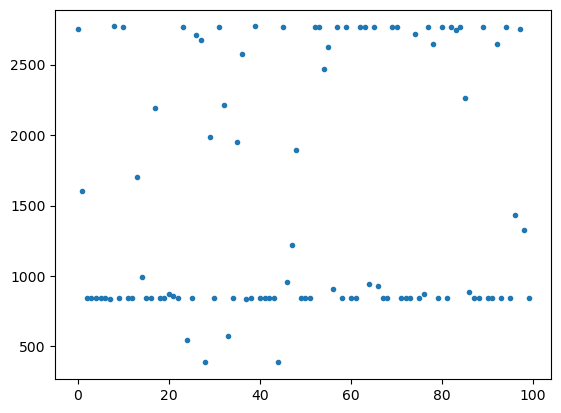

[0.02528953 1.89471094] 2.0 False {}
[0.08540703 2.76244267] 2.0 False {}
[0.14872077 2.56348385] 2.0 False {}
[0.22241068 2.99109287] 2.0 False {}
[0.28840743 2.36187607] 2.0 False {}
[0.34787386 2.38951188] 2.0 False {}
[0.4055174  2.24151045] 2.0 False {}
[0.45793803 1.9350626 ] 2.0000000000000004 False {}
[0.50574588 1.91472051] 2.000000000000001 False {}
[ 0.51405002 -1.34659327] -0.5999999999999988 False {}
[ 0.4384111  -4.69475133] 0.0 False {}
[ 0.28177536 -7.59523932] 0.0 False {}
[ 0.0612983  -9.82612315] 0.0 False {}
[ -0.20224021 -11.21898096] 0.0 False {}
[ -0.49050596 -11.70868087] 8.881784197001252e-16 False {}
[ -0.77979993 -11.37718801] 1.0675904604795505e-12 False {}
[ -1.05422446 -10.42471779] 2.0000000005184333 False {}
[-1.29852921 -9.0908991 ] 2.000000067195309 False {}
[-1.50841558 -7.60545424] 2.000002707764607 False {}
[-1.62718788 -1.97088223] 2.000017994156363 False {}
[-1.60975635  3.25318649] 2.0000137499626494 False {}
[-1.49556648  5.74383051] 2.000002187

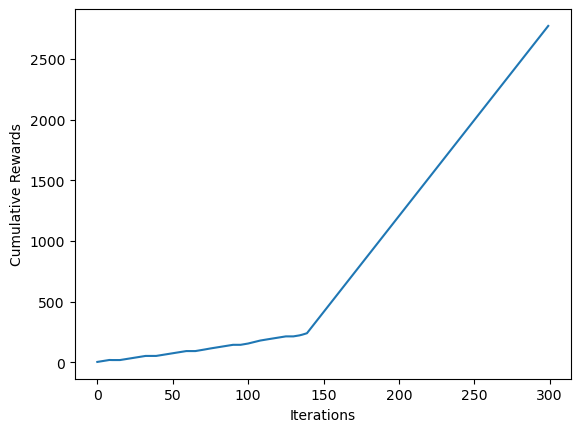

In [18]:

max_episode_steps = 1000 

env = gym.make('unbalanced-disk-v0', dt=0.025, umax=3.)
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps) #c)
env = Discretize(env, num_act=11)

# Define training (Hyper)-parameters
gamma = 0.99
batch_size = 32 
N_iterations = 10
N_rollout = 2000#0
N_epochs = 5
N_evals = 10
alpha_actor = 0.5
alpha_entropy = 0.6
lr = 5e-3


assert isinstance(env.action_space,gym.spaces.Discrete), 'action space requires to be discrete'

actor_crit = ActorCritic(env, num_hidden_act=40,num_hidden_cri=40)

saved_folder=os.path.abspath('saved_model')
best_model=os.path.join(saved_folder,'A2C-Best.pth')
actor_crit.load_state_dict(torch.load(best_model))

plt.plot([eval_actor(actor_crit, env) for i in range(100)],'.')
plt.show()
cum_rewards=show(actor_crit,env)

plt.plot(cum_rewards)
plt.xlabel('Iterations')
plt.ylabel('Cumulative Rewards')
plt.show()